# Урок 4. Методы

## Домашнее задание.

Используя базу данных NCBI Protein, узнайте, есть ли у белка, который кодирует выбранный на первом занятии ген, известная 3D-структура. Добавьте в таблицу переменную Yes/No, в зависимости от результатов поиска.

Посредством AlphaFold предскажите структуру белка, если она неизвестна. Если известна, найдите белок с неизвестной структурой и предскажите его 3D-структуру, воспользовавшись AlphaFold.

Сделанное практическое задание предоставляется в формате .ipynb.

https://colab.research.google.com/drive/1ZVq2QAf8Lj148qRb0JBHIU6wXjRrB9UE

## Задание выполнено командой M4 Team.
__Состав команды:__  
 - Мгер Парунакян
 - Михаил Демин
 - Марат Закиров
 - Марина Дружинина

In [1]:
try:
    import google.colab
    # Running on Google Colab, so install Biopython first
    !pip install biopython
except ImportError:
    pass


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 16.5 MB/s eta 0:00:00


In [2]:
from Bio import Entrez
Entrez.email = "A.N.Other@example.com"
from Bio import SeqIO
from Bio.Seq import MutableSeq
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
import pandas as pd
import xml.etree.ElementTree as ET

import re

In [129]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
%cd '/content/drive/MyDrive/Colab_Notebooks/GB'

/content/drive/MyDrive/Colab_Notebooks/GB


In [5]:
dis = pd.read_table('gene_disease_associations.tsv')
dis

gene_pli  score diseaseid  gene_dsi    protein_class_name  geneid  \
0    1.643200e-05   1.00  C0001080     0.391                Kinase    2261   
1    1.040000e-05   0.80  C0000744     0.505           Transporter    4547   
2    9.973100e-01   0.80  C0001193     0.380                Kinase    2263   
3    5.323500e-01   0.70  C0001418     0.236  Transcription factor    7157   
4    8.460200e-01   0.69  C0001126     0.522           Transporter    6521   
..            ...    ...       ...       ...                   ...     ...   
453  1.047800e-06   0.30  C0001430     0.578                   NaN    6948   
454  2.095700e-32   0.30  C0001430     0.419           Transporter    9429   
455  1.000000e+00   0.30  C0001546     0.552  Epigenetic regulator   10014   
456  8.919400e-01   0.30  C0001618     0.636      Enzyme modulator    2771   
457  9.998500e-01   0.30  C0001618     0.401                   NaN    5573   

       disease_class disease_type uniprotid  \
0            C16;C05      disease    P22607   
1            C16;C18      disease    P55157   
2            C16;C05      disease    P21802   
3                C04        group    P04637   
4    C16;C18;C13;C12    phenotype    P02730   
..               ...          ...       ...   
453              C04        group    P20062   
454              C04        group    Q9UNQ0   
455              F03        group    Q9UQL6   
456          C04;C19        group    P04899   
457          C04;C19        group    P10644   

                                    disease_class_name  \
0       Congenital, Hereditary, and Neonatal Diseas...   
1       Congenital, Hereditary, and Neonatal Diseas...   
2       Congenital, Hereditary, and Neonatal Diseas...   
3                                            Neoplasms   
4       Congenital, Hereditary, and Neonatal Diseas...   
..                                                 ...   
453                                          Neoplasms   
454                                          Neoplasms   
455                                   Mental Disorders   
456            Neoplasms;    Endocrine System Diseases   
457            Neoplasms;    Endocrine System Diseases   

                 disease_name          el  year_initial   source     ei  \
0              Achondroplasia  definitive        1994.0  CURATED  0.974   
1        Abetalipoproteinemia         NaN        1985.0  CURATED  0.982   
2              Apert syndrome         NaN        1994.0  CURATED  0.976   
3              Adenocarcinoma         NaN        1986.0  CURATED  0.975   
4      Renal tubular acidosis         NaN        1996.0  CURATED  1.000   
..                        ...         ...           ...      ...    ...   
453                   Adenoma         NaN        2007.0  CURATED  1.000   
454                   Adenoma         NaN        2011.0  CURATED  1.000   
455      Adjustment Disorders         NaN        2007.0  CURATED  1.000   
456  Tumors of Adrenal Cortex         NaN           NaN  CURATED    NaN   
457  Tumors of Adrenal Cortex         NaN           NaN  CURATED    NaN   

     gene_dpi protein_class  year_final gene_symbol  \
0       0.846  DTO_03300101      2020.0       FGFR3   
1       0.846  DTO_05007405      2019.0        MTTP   
2       0.808  DTO_03300101      2019.0       FGFR2   
3       0.962  DTO_05007542      2020.0        TP53   
4       0.731  DTO_05007405      2013.0      SLC4A1   
..        ...           ...         ...         ...   
453     0.615           NaN      2007.0        TCN2   
454     0.885  DTO_05007405      2011.0       ABCG2   
455     0.769  DTO_05007378      2007.0       HDAC5   
456     0.577  DTO_05007584         NaN       GNAI2   
457     0.846           NaN         NaN     PRKAR1A   

                disease_semantic_type  
0              Congenital Abnormality  
1                 Disease or Syndrome  
2              Congenital Abnormality  
3                  Neoplastic Process  
4                 Disease or Syndrome  
..      

## Задание к уроку 1

In [6]:
#Формируем таблицу генов по наименованию болезни
disease_db = dis.loc[dis['disease_name'] == 'Apert syndrome']
disease_db

gene_pli  score diseaseid  gene_dsi    protein_class_name  geneid  \
2     0.99731   0.80  C0001193     0.380                Kinase    2263   
126   0.34491   0.31  C0001193     0.397  Transcription factor    7291   

    disease_class disease_type uniprotid  \
2         C16;C05      disease    P21802   
126       C16;C05      disease    Q15672   

                                    disease_class_name    disease_name   el  \
2       Congenital, Hereditary, and Neonatal Diseas...  Apert syndrome  NaN   
126     Congenital, Hereditary, and Neonatal Diseas...  Apert syndrome  NaN   

     year_initial   source     ei  gene_dpi protein_class  year_final  \
2          1994.0  CURATED  0.976     0.808  DTO_03300101      2019.0   
126        2005.0  CURATED  1.000     0.846  DTO_05007542      2013.0   

    gene_symbol   disease_semantic_type  
2         FGFR2  Congenital Abnormality  
126      TWIST1  Congenital Abnormality

In [7]:
#Получаем список ID генов по наименованию болезни из таблицы
gene_id_list = disease_db['geneid'].tolist()
gene_id_list

[2263, 7291]

### Процедуры запроса необходимой информации из NCBI

In [8]:
#Запрашиваем ID хромосомы из NCBI через параметр 'gi_id'.
#Эта процедура применяется в общей процедуре сбора информации по генам(см. ячейку ниже)
def search_chromosome(gi_id):
    handle = Entrez.esummary(db="nucleotide", id=gi_id)
    record = Entrez.read(handle)
    handle.close()
    return record[0]['AccessionVersion']

In [9]:
def search_gene_name(gene_id):
  handle = Entrez.esummary(db="gene", id=gene_id)
  record = Entrez.read(handle)
  handle.close()
  return record['DocumentSummarySet']['DocumentSummary'][0]['Name']
  # print(record['DocumentSummarySet']['DocumentSummary'][0]['Name'])

In [10]:
#Получаем из NCBI информацию о генах из списка 'gene_id_list', в том числе ID хромосомы.
def get_gene_info(gene_id_list):
  gene_info = []
  for gene_id in gene_id_list:
    handle = Entrez.efetch(db="gene", id=gene_id, rettype = 'xml')
    gene_locus = ET.parse(handle).getroot().find("Entrezgene/Entrezgene_locus")
    region = gene_locus.find("Gene-commentary/Gene-commentary_seqs/Seq-loc/Seq-loc_int/Seq-interval")
    start = int(region.find("Seq-interval_from").text) + 1
    end = int(region.find("Seq-interval_to").text) + 1
    gi_id = region.find("Seq-interval_id/Seq-id/Seq-id_gi").text
    strand = region.find("Seq-interval_strand/Na-strand").get("value")
    # print(gene_id, start, end, gi_id, strand)
    gene_info.append({'gene_name':search_gene_name(gene_id), 'gene_id':gene_id, 'interval_from':start, 'interval_to':end, 'gi_id':gi_id, 'nucleotide':search_chromosome(gi_id), 'strand':strand})
  return gene_info

In [11]:
# Вытаскиваем ген из БД `gene` напрямую по наименованию болезни(необходимо прописать интересующий ген в `term`)
# handle = Entrez.esearch(db="gene", term="Homo sapiens[Organism] AND FGFR2[Gene] AND Apert syndrome")
# record = Entrez.read(handle)
# gene_id = record["IdList"][0]
# print("Gene ID:", record["IdList"][0])

In [12]:
%%time
#Формируем список по всем генам
gene_list = get_gene_info(gene_id_list)
for i in gene_list:
  print(i)

{'gene_name': 'FGFR2', 'gene_id': 2263, 'interval_from': 121478330, 'interval_to': 121598458, 'gi_id': '568815588', 'nucleotide': 'NC_000010.11', 'strand': 'minus'}
{'gene_name': 'TWIST1', 'gene_id': 7291, 'interval_from': 19113047, 'interval_to': 19117636, 'gi_id': '568815591', 'nucleotide': 'NC_000007.14', 'strand': 'minus'}
CPU times: user 584 ms, sys: 49.7 ms, total: 633 ms
Wall time: 2.41 s


In [13]:
#Предоставляем список генов в виде таблицы
df = pd.DataFrame(gene_list).head(1)
df['accession'] = df['nucleotide'].apply(lambda x: x.split('.')[0])
df['version'] = df['nucleotide'].apply(lambda x: x.split('.')[1])

In [14]:
df.T

0
gene_name             FGFR2
gene_id                2263
interval_from     121478330
interval_to       121598458
gi_id             568815588
nucleotide     NC_000010.11
strand                minus
accession         NC_000010
version                  11

## Задание к уроку 2

In [15]:
#Получаем нуклеотидную последовательность гена. Параметры берем из 'gene_list'
def get_dna_sequence(gene_seq_keys_list):
  for nucleotid in gene_seq_keys_list:
    nucleotid_id = nucleotid['nucleotide']
    start = nucleotid['interval_from']
    end = nucleotid['interval_to']
    handle = Entrez.efetch(db="nucleotide",
                        id=nucleotid_id, 
                        rettype = 'fasta',
                        retmode = 'text')
    #загружаем нуклеотидную последовательность хромосомы
    chromosome = SeqIO.read(handle, 'fasta')
    gene_sym = chromosome.seq[start:end]
    print(f'Gene ID: {nucleotid["gene_id"]}')
    # print('Chromosome description: ' + chromosome.description)
    # print('Gene sequence: ' + gene_sym)
    # print('Gene sequence length: ' + str(len(gene_sym)) + '\n')
    # print(('=' * 100) + '\n')
    return gene_sym

In [16]:
%%time
gene_seq = get_dna_sequence(gene_list)
print(gene_seq)

Gene ID: 2263
ATTAAAAAAATAAGTTGCGTGACATTTATTTTGTCTTGTTAACATTAATATCTGTAGAAACATTTTTATTGTCAGTATAAAAATTAACAGGTTTTATTAAATACTTTCTCCAATTTTGTAACACATAAGATCAGTGTAATCTGCATTCATCTTGCACGGCTATTGCAAAGTGAGTGGGTGTTTCCAAAGCAAAACACAATACTTTAGTACAGAAGGAACAACGGCGATATTTTGTCTGATGTAGGTATGAGGCTGGATCTTTTGGTGAGGTCCTGCCAGAATTAGATGAAAGCAATCCCTTAAAAAGATGGACGTATCCCCAAAACTATCAGCAGAACAACTCTGTGTTTCAATTTTCTATGATGGGACTTGAAGATCCTAACAGGCGTCTCCAACGCCAAAGAGTCTGGAAGCCATTATCAAAATTCACTGAAGAGAATACAGGCTAATCTGATTAATGTGCAACTCAGAAGCAGAAGGCCAGCTGCCAGAGAGAAGCACATTCTGCTATCATTTCAACTAAGGTCTGTCCTCAAGGAATGGATTAAGGCATCTTTTAAGAGGACGCTGGTACCATTTATCTTGGGAAGTCCAGTTAGACGTTGCGTTGACGTAATGACAGGGTTGCACACCAAAATGAAACACCTTCCTATGAATGAGTTCTTTTAATATGGGGCATTTAGGAGGTCTAAGAACAATCGTCTGACAGCAGCATTTAAACACAAATAAATCAAAACTTCATTTTCCCCAAATTAGTCATATATTGTAAATATTCTCTTTTCAAAGGATCTGATAACTAGTTAAGTCCAAGCAATAGATTAACTAGTCTGCTGTGCTGCCTGCATAGAAATGCCACTTAAATTACAAAAAAAACTATAAATGATTAATTGTTTTGTATATTACCAATTTATTAATAAATTAACGTTATACCATTTTCCCTGAAAGCAAAAGTATTTTTCCACCTCTGCTCGGTGAAAATTAAGAAA

In [17]:
len(gene_seq)

120128

#### Так как ген FGFR2 находится на отрицательной ветви 10 хромосомы нам необходимо комплементарно перевернуть последовательность. Создаем новый объект `plus_strand_seq` которым является комплементарный участок положительной ветви.

In [18]:
plus_strand_seq = gene_seq.reverse_complement()
print(plus_strand_seq)

GGCGGCGGCTGGAGGAGAGCGCGGTGGAGAGCCGAGCGGGCGGGCGGCGGGTGCGGAGCGGGCGAGGGAGCGCGCGCGGCCGCCACAAAGCTCGGGCGCCGCGGGGCTGCATGCGGCGTACCTGGCCCGGCGCGGCGACTGCTCTCCGGGCTGGCGGGGGCCGGCCGCGAGCCCCGGGGGCCCCGAGGCCGCAGCTTGCCTGCGCGCTCTGAGCCTTCGCAACTCGCGAGCAAAGTTTGGTGGAGGCAACGCCAAGCCTGAGTCCTTTCTTCCTCTCGTTCCCCAAATCCGAGGGCAGCCCGCGGGCGTCATGCCCGCGCTCCTCCGCAGCCTGGGGTACGCGTGAAGCCCGGGAGGCTTGGCGCCGGCGAAGACCCAAGGACCACTCTTCTGCGTTTGGAGTTGCTCCCCGCAACCCCGGGCTCGTCGCTTTCTCCATCCCGACCCACGCGGGGCGCGGGGACAACACAGGTCGCGGAGGAGCGTTGCCATTCAAGGTAATCGCCGCGCAAGACGCCTCGGGGAGCTTCGCCAGCCGGGGACGTGGGCGCCACGGGAGCCCGGGACGCCGGGTGCACCGTCCTCCGGGCGGGGGGCGCGGAAGGACTAGCATTGTGGAGGACGCTCCGTGTCCTCCCTCTGTGGCTGCATAGGTGATGGGGGAGGTGGGTGCGTGCTGACGGCCGGCGTTCTGGAAGTTCTGCCTCTGCTACCCCCATCCAGATGCTGACATCTGCTTCTGGCGTTGACGCCCCCCTCCCTGTCAAACCCTGGCGGGCGCATTCCCGCTGACTGGGCGCGTTTCTCCGACCCCAGAGCAGACGGGCGGAAGGTTCGCCTGCCCGTGGCACAGCCCCGCAGGCCGGTTCCCGGGGTCATCTCCGAGGTGCCCCATCCGTGTGTCCTGGGAACTTCCGTACCATCCAGGCCCTGCGGAGACCCCTTTTTCGGGAGGGGGCCGCTGGGGTGGGGCCGGTGACATCCCGTAGGGGTGGCGATG

#### Теперь нам нужен комплементарный участок отрицательной ветви. Заменяем все основания в соответствии с правилами Уотсона-Крика: A -> T, T -> A, G -> C, C -> G.

In [19]:
minus_strand_seq = plus_strand_seq.complement()
print(minus_strand_seq)

CCGCCGCCGACCTCCTCTCGCGCCACCTCTCGGCTCGCCCGCCCGCCGCCCACGCCTCGCCCGCTCCCTCGCGCGCGCCGGCGGTGTTTCGAGCCCGCGGCGCCCCGACGTACGCCGCATGGACCGGGCCGCGCCGCTGACGAGAGGCCCGACCGCCCCCGGCCGGCGCTCGGGGCCCCCGGGGCTCCGGCGTCGAACGGACGCGCGAGACTCGGAAGCGTTGAGCGCTCGTTTCAAACCACCTCCGTTGCGGTTCGGACTCAGGAAAGAAGGAGAGCAAGGGGTTTAGGCTCCCGTCGGGCGCCCGCAGTACGGGCGCGAGGAGGCGTCGGACCCCATGCGCACTTCGGGCCCTCCGAACCGCGGCCGCTTCTGGGTTCCTGGTGAGAAGACGCAAACCTCAACGAGGGGCGTTGGGGCCCGAGCAGCGAAAGAGGTAGGGCTGGGTGCGCCCCGCGCCCCTGTTGTGTCCAGCGCCTCCTCGCAACGGTAAGTTCCATTAGCGGCGCGTTCTGCGGAGCCCCTCGAAGCGGTCGGCCCCTGCACCCGCGGTGCCCTCGGGCCCTGCGGCCCACGTGGCAGGAGGCCCGCCCCCCGCGCCTTCCTGATCGTAACACCTCCTGCGAGGCACAGGAGGGAGACACCGACGTATCCACTACCCCCTCCACCCACGCACGACTGCCGGCCGCAAGACCTTCAAGACGGAGACGATGGGGGTAGGTCTACGACTGTAGACGAAGACCGCAACTGCGGGGGGAGGGACAGTTTGGGACCGCCCGCGTAAGGGCGACTGACCCGCGCAAAGAGGCTGGGGTCTCGTCTGCCCGCCTTCCAAGCGGACGGGCACCGTGTCGGGGCGTCCGGCCAAGGGCCCCAGTAGAGGCTCCACGGGGTAGGCACACAGGACCCTTGAAGGCATGGTAGGTCCGGGACGCCTCTGGGGAAAAAGCCCTCCCCCGGCGACCCCACCCCGGCCACTGTAGGGCATCCCCACCGCTAC

#### Преобразуем последовательности ДНК в РНК путем замены каждого вхождения тимина (T) урацилом (U) в соответствии с правилами комплементарности Уотсона-Крика.

In [20]:
m_rna = minus_strand_seq.transcribe()
m_rna

Seq('CCGCCGCCGACCUCCUCUCGCGCCACCUCUCGGCUCGCCCGCCCGCCGCCCACG...UUA')

In [21]:
len(m_rna)

120128

In [22]:
# Найдем вхождение старт-кодона в последовательности мРНК и отбросим все что до старт-кодона
str(m_rna).find('AUG')

118

In [23]:
# Отображение последовательности по триплетам
def show_in_triplets(seq):
  triplets = re.sub('(.{3})', r'\1 ', str(seq)).split(' ')
  return triplets

In [24]:
show_in_triplets(m_rna[115:124])

['CGC', 'AUG', 'GAC', '']

In [25]:
m_rna_start_translation = m_rna[118::]
m_rna_start_translation

Seq('AUGGACCGGGCCGCGCCGCUGACGAGAGGCCCGACCGCCCCCGGCCGGCGCUCG...UUA')

In [26]:
# m_rna_start = str(m_rna).partition('AUG')
# m_rna_start_translation = ''.join(m_rna_start[1::])
# print(m_rna_start_translation)
# print(len(m_rna_start_translation))

In [27]:
len(m_rna_start_translation)

120010

#### Произведем трансляцию РНК в белок.

In [28]:
protein = Seq(m_rna_start_translation).translate()
protein

/usr/local/lib/python3.9/dist-packages/Bio/Seq.py:2804: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  warnings.warn(


Seq('MDRAAPLTRGPTAPGRRSGPPGLRRRTDARDSEALSARFKPPPLRFGLRKEGEQ...KKI')

In [29]:
len(protein)

40003

In [30]:
# Добавим последовательность белка в таблицу
df['prot.seq.example'] = str(protein)

In [31]:
# Сохраняем полученную последовательность белка в файл
record = SeqRecord(protein, id="FGFR2 Gene ID: 2263", description="translated Human fibroblast growth factor receptor 2 protein sequence")
outputname = '2263_FGFR2_protein.fasta'
SeqIO.write(record, outputname, 'fasta')

1

In [32]:
# Получим список баз которым можно обратиться через модуль `Entrez`
handle = Entrez.einfo()
record = Entrez.read(handle)
handle.close()
record

{'DbList': ['pubmed', 'protein', 'nuccore', 'ipg', 'nucleotide', 'structure', 'genome', 'annotinfo', 'assembly', 'bioproject', 'biosample', 'blastdbinfo', 'books', 'cdd', 'clinvar', 'gap', 'gapplus', 'grasp', 'dbvar', 'gene', 'gds', 'geoprofiles', 'homologene', 'medgen', 'mesh', 'nlmcatalog', 'omim', 'orgtrack', 'pmc', 'popset', 'proteinclusters', 'pcassay', 'protfam', 'pccompound', 'pcsubstance', 'seqannot', 'snp', 'sra', 'taxonomy', 'biocollections', 'gtr']}

In [33]:
# Получаем список транскрипций по имени гена из базы `nuccore`
handle = Entrez.esearch(db="nuccore",
                        term='FGFR2[Gene Name] AND "homo sapiens"[Organism] AND RefSeq[Keyword]',
                        # usehistory="y",
                        retmax=30)
record = Entrez.read(handle)
handle.close()
record

{'Count': '27', 'RetMax': '27', 'RetStart': '0', 'IdList': ['1889498142', '1889443442', '1771805607', '1677539445', '1677531698', '1677529853', '1677501539', '2324154561', '1890284386', '1701948118', '394025691', '222144232', '222144230', '1004170713', '2194973501', '568815588', '2217276108', '2217276107', '2217276106', '2217276105', '2217276104', '2217276103', '2217276102', '2217276101', '2217276100', '2217276099', '2217276098'], 'TranslationSet': [{'From': '"homo sapiens"[Organism]', 'To': '"Homo sapiens"[Organism]'}], 'TranslationStack': [{'Term': 'FGFR2[Gene Name]', 'Field': 'Gene Name', 'Count': '4785', 'Explode': 'N'}, {'Term': '"Homo sapiens"[Organism]', 'Field': 'Organism', 'Count': '28318073', 'Explode': 'Y'}, 'AND', {'Term': 'RefSeq[Keyword]', 'Field': 'Keyword', 'Count': '94199127', 'Explode': 'N'}, 'AND'], 'QueryTranslation': 'FGFR2[Gene Name] AND "Homo sapiens"[Organism] AND RefSeq[Keyword]'}

In [34]:
transcript_id_list = record['IdList']
transcript_id_list

['1889498142', '1889443442', '1771805607', '1677539445', '1677531698', '1677529853', '1677501539', '2324154561', '1890284386', '1701948118', '394025691', '222144232', '222144230', '1004170713', '2194973501', '568815588', '2217276108', '2217276107', '2217276106', '2217276105', '2217276104', '2217276103', '2217276102', '2217276101', '2217276100', '2217276099', '2217276098']

In [35]:
# Выгрузим информацию обо всех транскрипциях гена из `transcript_id_list` 
def get_transcriptions_info(transcript_id_list):
  transcript_info = []
  for i in transcript_id_list:
    handle = Entrez.efetch(db="nuccore",
                           id=i,
                           rettype = 'gb',
                           retmode = 'text')
    info = SeqIO.read(handle, 'gb')
    if str(info.name).find('NC') and str(info.name).find('NG'):
      transcript_info.append({'id':info.id, 'name':info.name, 'seq':info.seq, 'description':info.description})
    # print(info.name)
    # print(info.seq)
  return transcript_info

In [36]:
transcriptions_list = get_transcriptions_info(transcript_id_list)

In [37]:
for transcript in transcriptions_list:
  print(transcript)
  # print('=' * 200)

{'id': 'NM_001144915.2', 'name': 'NM_001144915', 'seq': Seq('AATTTGTTGAGGAATTTCCCCCTAGCCTTGACCCCTTGACAGCTCCCGCTCCTA...TAA'), 'description': 'Homo sapiens fibroblast growth factor receptor 2 (FGFR2), transcript variant 5, mRNA'}
{'id': 'NM_001144916.2', 'name': 'NM_001144916', 'seq': Seq('GAGCACACATTGCCTCACTGAAGTGGCTGCACGTATCTGAGTCCTGTAGCTACT...TAA'), 'description': 'Homo sapiens fibroblast growth factor receptor 2 (FGFR2), transcript variant 6, mRNA'}
{'id': 'NM_000141.5', 'name': 'NM_000141', 'seq': Seq('GAGAGCGCGGTGGAGAGCCGAGCGGGCGGGCGGCGGGTGCGGAGCGGGCGAGGG...TAA'), 'description': 'Homo sapiens fibroblast growth factor receptor 2 (FGFR2), transcript variant 1, mRNA'}
{'id': 'NM_001144918.2', 'name': 'NM_001144918', 'seq': Seq('GAGAGCGCGGTGGAGAGCCGAGCGGGCGGGCGGCGGGTGCGGAGCGGGCGAGGG...TAA'), 'description': 'Homo sapiens fibroblast growth factor receptor 2 (FGFR2), transcript variant 8, mRNA'}
{'id': 'NM_001144917.2', 'name': 'NM_001144917', 'seq': Seq('GAGAGCGCGGTGGAGAGCCGAGCGGGCGGGCGG

In [38]:
# Находим самую длинную транскрипцию
def find_longest_transcript(transcriptions_list):
  max = 0
  for i in transcriptions_list:
    if len(i.get('seq')) > max:
      max = len(i.get('seq'))
  return max, i.get('name'), i.get('seq'), i.get('description')

In [39]:
longest_transcript = find_longest_transcript(transcriptions_list)
longest_transcript

(4733,
 'XM_006717708',
 Seq('GGCGGCGGCTGGAGGAGAGCGCGGTGGAGAGCCGAGCGGGCGGGCGGCGGGTGC...ATA'),
 'PREDICTED: Homo sapiens fibroblast growth factor receptor 2 (FGFR2), transcript variant X1, mRNA')

In [40]:
longest_transcript[2].transcribe().translate()

/usr/local/lib/python3.9/dist-packages/Bio/Seq.py:2804: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  warnings.warn(


Seq('GGGWRRARWRAERAGGGCGAGEGARAAATKLGRRGAACGVPGPARRLLSGLAGA...FF*')

In [41]:
# Переведем нуклеотидную последовательность самой длинной транскрипции в белок
long_trans_protein = longest_transcript[2].transcribe().translate()
long_trans_protein

Seq('GGGWRRARWRAERAGGGCGAGEGARAAATKLGRRGAACGVPGPARRLLSGLAGA...FF*')

In [42]:
# Добавим сведения о транскрипциях в таблицу
df['gr_acid_num'] = len(long_trans_protein)
df['num_of_transcripts'] = len(transcriptions_list)

In [43]:
df.T

0
gene_name                                                       FGFR2
gene_id                                                          2263
interval_from                                               121478330
interval_to                                                 121598458
gi_id                                                       568815588
nucleotide                                               NC_000010.11
strand                                                          minus
accession                                                   NC_000010
version                                                            11
prot.seq.example    MDRAAPLTRGPTAPGRRSGPPGLRRRTDARDSEALSARFKPPPLRF...
gr_acid_num                                                      1545
num_of_transcripts                                                 24

## Задание к уроку 3

In [44]:
# Получаем список ID всех missense мутаций по  ID гена из базы `snp`
handle = Entrez.esearch(db="snp",
                        term='2263[Gene ID] AND "homo sapiens"[Organism] AND "pathogenic"[Clinical Significance] AND "missense variant"[Function Class]',
                        # usehistory="y",
                        retmax=100)
record = Entrez.read(handle)
handle.close()
record

{'Count': '49', 'RetMax': '49', 'RetStart': '0', 'IdList': ['2134256250', '1850289942', '1847510893', '1845559552', '1589722765', '1564919048', '1554928884', '1554927408', '1434545235', '1358919643', '1274989878', '1057519047', '1057519044', '1057519043', '1057519040', '1057519039', '1057519037', '1057519036', '776587763', '387907372', '387906678', '387906677', '387906676', '281865420', '121918510', '121918509', '121918508', '121918507', '121918506', '121918505', '121918504', '121918502', '121918501', '121918500', '121918499', '121918497', '121918496', '121918495', '121918494', '121918493', '121918492', '121918490', '121918489', '121918488', '121918487', '121913478', '121913477', '79184941', '77543610'], 'TranslationSet': [], 'TranslationStack': [{'Term': '2263[Gene ID]', 'Field': 'Gene ID', 'Count': '51388', 'Explode': 'N'}, {'Term': '"homo sapiens"[Organism]', 'Field': 'Organism', 'Count': '1116839409', 'Explode': 'Y'}, 'AND', {'Term': '"pathogenic"[Clinical Significance]', 'Field': 

In [45]:
rs_list = record['IdList']
rs_list

['2134256250', '1850289942', '1847510893', '1845559552', '1589722765', '1564919048', '1554928884', '1554927408', '1434545235', '1358919643', '1274989878', '1057519047', '1057519044', '1057519043', '1057519040', '1057519039', '1057519037', '1057519036', '776587763', '387907372', '387906678', '387906677', '387906676', '281865420', '121918510', '121918509', '121918508', '121918507', '121918506', '121918505', '121918504', '121918502', '121918501', '121918500', '121918499', '121918497', '121918496', '121918495', '121918494', '121918493', '121918492', '121918490', '121918489', '121918488', '121918487', '121913478', '121913477', '79184941', '77543610']

In [46]:
# Получаем информацию по каждой мутации из списка
def get_snp_rs_info(rs_list):
  snp_rs_info = []
  for i in rs_list:
    handle = Entrez.esearch(db="snp", term="rs" + i)
    record = Entrez.read(handle)
    handle.close()
    idlist = record["IdList"]
    if len(idlist) > 0:
        handle = Entrez.esummary(db="snp", id=",".join(idlist))
        result = Entrez.read(handle)
        handle.close()
        snp_info = result['DocumentSummarySet']['DocumentSummary'][0]
        snp_rs_info.append({'SNP_ID':snp_info['SNP_ID'], 'GENES':snp_info['GENES'], 'ACC':snp_info['ACC'], 'SPDI':snp_info['SPDI']})
  return snp_rs_info

In [47]:
# Возьмем небольшое количество ID из предыдущего запроса
rs_tiny = rs_list[5 : 7]
rs_tiny

['1564919048', '1554928884']

In [49]:
rs_sample = get_snp_rs_info(rs_tiny)
rs_sample

[{'SNP_ID': '1564919048',
  'GENES': [{'NAME': 'FGFR2', 'GENE_ID': '2263'}],
  'ACC': 'NC_000010.11',
  'SPDI': 'NC_000010.11:121520105:C:A,NC_000010.11:121520105:C:G,NC_000010.11:121520105:C:T'},
 {'SNP_ID': '1554928884',
  'GENES': [{'NAME': 'FGFR2', 'GENE_ID': '2263'}],
  'ACC': 'NC_000010.11',
  'SPDI': 'NC_000010.11:121517383:T:A,NC_000010.11:121517383:T:C'}]

In [50]:
# Добавим сведения о количестве missense мутаций FGFR2 в таблицу
df['rs'] = len(rs_list)
df.T

0
gene_name                                                       FGFR2
gene_id                                                          2263
interval_from                                               121478330
interval_to                                                 121598458
gi_id                                                       568815588
nucleotide                                               NC_000010.11
strand                                                          minus
accession                                                   NC_000010
version                                                            11
prot.seq.example    MDRAAPLTRGPTAPGRRSGPPGLRRRTDARDSEALSARFKPPPLRF...
gr_acid_num                                                      1545
num_of_transcripts                                                 24
rs                                                                 49

In [51]:
# Создаем копию оригинального гена
mutable_seq = MutableSeq(minus_strand_seq)
mutable_seq

MutableSeq('CCGCCGCCGACCTCCTCTCGCGCCACCTCTCGGCTCGCCCGCCCGCCGCCCACG...TTA')

In [52]:
# Найдем старт кодон
def find_start_codon_dna(mutable_seq):
  return str(mutable_seq).find('ATG')

In [53]:
# Выделим последовательность гена после старт кодона
start = find_start_codon_dna(mutable_seq)
semantic_seq = mutable_seq[start::]
semantic_seq

MutableSeq('ATGGACCGGGCCGCGCCGCTGACGAGAGGCCCGACCGCCCCCGGCCGGCGCTCG...TTA')

Старт кодон находится в 118-120 положении ДНК. Участок 118-306
 нуклеотид ДНК будем использовать для мутаций синонимичной замены, миссенс и нонсенс мутаций

In [54]:
# Отобразим исходную последовательность белка
semantic_seq.transcribe().translate()

/usr/local/lib/python3.9/dist-packages/Bio/Seq.py:2804: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  warnings.warn(


MutableSeq('MDRAAPLTRGPTAPGRRSGPPGLRRRTDARDSEALSARFKPPPLRFGLRKEGEQ...KKI')

### True Silence mutation
Для данной мутации мы заменим первый триплет в начале последовательности нашего гена.

In [55]:
# Скопируем исходный ген в новую переменную
true_silence_seq = mutable_seq

In [56]:
# Отобразим нужный участок последовательности нуклеотидов
true_silence_seq[0:9]

MutableSeq('CCGCCGCCG')

In [57]:
# Заменим первые три нуклеотида последовательноси 'CCG' на 'TCT'
true_silence_seq[0:3] = "TCT"
true_silence_seq[0:9]

MutableSeq('TCTCCGCCG')

In [58]:
# Отобразим последовательность белка после изменений (старт кодон в 118 положении)
start = find_start_codon_dna(true_silence_seq)
true_silence_seq[start::].transcribe().translate()

MutableSeq('MDRAAPLTRGPTAPGRRSGPPGLRRRTDARDSEALSARFKPPPLRFGLRKEGEQ...KKI')

In [59]:
# Сравним белковые последовательности до и после изменений
semantic_seq.transcribe().translate() == true_silence_seq[start::].transcribe().translate()

True

Последовательность белка не изменилась

### Synonimic mutation
Для этой и последующих мутаций возьмем участок гена после старт-кодона.
Для этого найдем в нуклеотидной последовательности гена позицию первого вхождения триплета `ATG` (`AUG` в мРНК)

In [60]:
# Скопируем исходный ген в новую переменную
synonimic_seq = semantic_seq
synonimic_seq

MutableSeq('ATGGACCGGGCCGCGCCGCTGACGAGAGGCCCGACCGCCCCCGGCCGGCGCTCG...TTA')

Для удобства отобразим участок нуклеотидной последовательности по триплетам, обозначим старт и стоп кодоны в коде ДНК, укажем позиции нуклеотидов (1-я буква триплета) и соответствующих им аминокислот

In [61]:
# Функция отображения ДНК по триплетам
def view_triplets_dna(string):
  protein_seq_pos_num = 0
  dna_seq = 0 
  codons = [string[i:i+3] for i in range(0, len(string), 3)]
  for triplet in codons:
    if triplet == 'ATG':
      print(f'{protein_seq_pos_num}  {dna_seq}  {triplet}  <<<---START CODON')
    elif triplet == 'TAG' or triplet == 'TGA' or triplet == 'TAA':
      print(f'{protein_seq_pos_num}  {dna_seq}  {triplet}  <<<---STOP CODON')
    else:
      print(f'{protein_seq_pos_num}  {dna_seq}  {triplet}')
    dna_seq += 3
    protein_seq_pos_num += 1

In [62]:
show_in_triplets(synonimic_seq[:30])

['ATG', 'GAC', 'CGG', 'GCC', 'GCG', 'CCG', 'CTG', 'ACG', 'AGA', 'GGC', '']

In [63]:
view_triplets_dna(synonimic_seq[:189])

0  0  ATG  <<<---START CODON
1  3  GAC
2  6  CGG
3  9  GCC
4  12  GCG
5  15  CCG
6  18  CTG
7  21  ACG
8  24  AGA
9  27  GGC
10  30  CCG
11  33  ACC
12  36  GCC
13  39  CCC
14  42  GGC
15  45  CGG
16  48  CGC
17  51  TCG
18  54  GGG
19  57  CCC
20  60  CCG
21  63  GGG
22  66  CTC
23  69  CGG
24  72  CGT
25  75  CGA
26  78  ACG
27  81  GAC
28  84  GCG
29  87  CGA
30  90  GAC
31  93  TCG
32  96  GAA
33  99  GCG
34  102  TTG
35  105  AGC
36  108  GCT
37  111  CGT
38  114  TTC
39  117  AAA
40  120  CCA
41  123  CCT
42  126  CCG
43  129  TTG
44  132  CGG
45  135  TTC
46  138  GGA
47  141  CTC
48  144  AGG
49  147  AAA
50  150  GAA
51  153  GGA
52  156  GAG
53  159  CAA
54  162  GGG
55  165  GTT
56  168  TAG  <<<---STOP CODON
57  171  GCT
58  174  CCC
59  177  GTC
60  180  GGG
61  183  CGC
62  186  CCG


In [64]:
synonimic_seq[:189]

MutableSeq('ATGGACCGGGCCGCGCCGCTGACGAGAGGCCCGACCGCCCCCGGCCGGCGCTCG...CCG')

In [65]:
synonimic_seq[:189].transcribe().translate()

MutableSeq('MDRAAPLTRGPTAPGRRSGPPGLRRRTDARDSEALSARFKPPPLRFGLRKEGEQ...GRP')

Как мы видим в начале аминокислотной последовательности белка есть несколько аминокислот 'Аланин'. Посмотрим их кодоны и попробуем заменить так, чтобы аминокислотная последовательность не изменилась

In [66]:
# Отобразим нужный участок последовательности нуклеотидов
synonimic_seq[:15]

MutableSeq('ATGGACCGGGCCGCG')

In [67]:
# Отобразим белковую последовательность выбранного участка
synonimic_seq[0:21].transcribe().translate()

MutableSeq('MDRAAPL')

Аминокислота 'Аланин' кодируется одним из четырех триплетов: 'GCT', 'GCC', 'GCA' или 'GCG'. Заменим 2 триплета 'GCC' и 'GCG' в положении 9-14 на 'GCA' и 'GCT'.

In [68]:
# Заменим последовательность нуклеотидов
synonimic_seq[9:12] = "GCA"
synonimic_seq[12:15] = "GCT"
synonimic_seq[:15]

MutableSeq('ATGGACCGGGCAGCT')

In [69]:
# Отобразим мутантную последовательность белка
synonimic_seq[:21].transcribe().translate()

MutableSeq('MDRAAPL')

In [70]:
# Сравним белковые последовательности до и после изменений
semantic_seq.transcribe().translate() == synonimic_seq.transcribe().translate()

True

Не смотря на изменение кода ДНК аминокислотный состав белка остался тем же

### Missense mutation

In [71]:
# Скопируем исходный ген в новую переменную и отбросим нуклеотиды до старт-кодона
missense_seq = semantic_seq
missense_seq

MutableSeq('ATGGACCGGGCAGCTCCGCTGACGAGAGGCCCGACCGCCCCCGGCCGGCGCTCG...TTA')

In [72]:
# Отобразим нужный участок последовательности нуклеотидов
missense_seq[:33]

MutableSeq('ATGGACCGGGCAGCTCCGCTGACGAGAGGCCCG')

In [73]:
# Отобразим белковую последовательность выбранного участка
missense_seq[:33].transcribe().translate()

MutableSeq('MDRAAPLTRGP')

Для missense-мутации заменим аминокислоту 'Аргинин' в 9-м положении на 'Аспарагиновую кислоту'. Для этого поменяем триплет 'AGA' [24-26] на 'GAC'

In [74]:
# Заменим последовательность нуклеотидов
missense_seq[24:27] = "GAC"
missense_seq[:27]

MutableSeq('ATGGACCGGGCAGCTCCGCTGACGGAC')

In [75]:
# Отобразим мутантную последовательность белка
missense_seq[:33].transcribe().translate()

MutableSeq('MDRAAPLTDGP')

### Nonsense mutation

In [76]:
# Скопируем исходный ген в новую переменную и отбросим нуклеотиды до старт-кодона
nonsense_seq = semantic_seq
nonsense_seq

MutableSeq('ATGGACCGGGCAGCTCCGCTGACGGACGGCCCGACCGCCCCCGGCCGGCGCTCG...TTA')

In [77]:
# Отобразим нужный участок последовательности нуклеотидов
nonsense_seq[:51]

MutableSeq('ATGGACCGGGCAGCTCCGCTGACGGACGGCCCGACCGCCCCCGGCCGGCGC')

In [78]:
# Отобразим белковую последовательность выбранного участка
nonsense_seq[:51].transcribe().translate()

MutableSeq('MDRAAPLTDGPTAPGRR')

In [79]:
# Заменим последовательность нуклеотидов 'CCG' [30-32] на 'TAA'
nonsense_seq[30:33] = "TAA"
nonsense_seq[:33]

MutableSeq('ATGGACCGGGCAGCTCCGCTGACGGACGGCTAA')

In [80]:
# Отобразим мутантную последовательность белка
nonsense_seq[:51].transcribe().translate()

MutableSeq('MDRAAPLTDG*TAPGRR')

В 11-м положении белковой последовательности вместо аминокислоты 'Пролин' (P) появился стоп-кодон. Теперь синтез белка останавливается в этом месте 

### Проверка

In [81]:
t =   Seq('CCG')
t.transcribe().translate()

Seq('P')

In [82]:
t =   Seq('CCCGACGUACGCCGCAUG')
t.translate()

Seq('PDVRRM')

## Задание к уроку 4

In [83]:
# Получаем список ID по имени гена из базы `structure`
handle = Entrez.esearch(db="structure",
                        term='FGFR2[Gene Name] AND "homo sapiens"[Organism]',
                        # usehistory="y",
                        retmax=40)
record = Entrez.read(handle)
handle.close()
record

{'Count': '39', 'RetMax': '39', 'RetStart': '0', 'IdList': ['186071', '186070', '160290', '147610', '147609', '147608', '147607', '136254', '117620', '112457', '112456', '112455', '112454', '112453', '93259', '93258', '90355', '76215', '70964', '69410', '69282', '64915', '62716', '59356', '59354', '59353', '59344', '59340', '59330', '59329', '59328', '59318', '29836', '22184', '20029', '16112', '16111', '14616', '13371'], 'TranslationSet': [], 'TranslationStack': [{'Term': 'FGFR2[Gene Name]', 'Field': 'Gene Name', 'Count': '40', 'Explode': 'N'}, {'Term': '"homo sapiens"[Organism]', 'Field': 'Organism', 'Count': '60915', 'Explode': 'Y'}, 'AND'], 'QueryTranslation': 'FGFR2[Gene Name] AND "homo sapiens"[Organism]'}

In [84]:
mmdb_id_list = record['IdList']
mmdb_id_list

['186071', '186070', '160290', '147610', '147609', '147608', '147607', '136254', '117620', '112457', '112456', '112455', '112454', '112453', '93259', '93258', '90355', '76215', '70964', '69410', '69282', '64915', '62716', '59356', '59354', '59353', '59344', '59340', '59330', '59329', '59328', '59318', '29836', '22184', '20029', '16112', '16111', '14616', '13371']

In [85]:
# record

In [86]:
# Получим сведения обо всех известных 3D структурах из базы 'structure'
def get_pdb_summary(mmdb_id_list):
  pdb_info = []
  for i in mmdb_id_list:
    handle = Entrez.esummary(db='structure', id=i)
    record = Entrez.read(handle)
    info = record[0]
    pdb_info.append({'MMDB ID':info['Id'],
                     'PDB ID':info['PdbAcc'],
                     'Description':info['PdbDescr'],
                     'Class':info['PdbClass'],
                     'PDB Download link':f'https://files.rcsb.org/download/{info["PdbAcc"]}.pdb'})
  return pdb_info

In [87]:
pdb_list = pd.DataFrame(get_pdb_summary(mmdb_id_list))
pdb_list.head(5)

MMDB ID PDB ID                                        Description  \
0  186071   6LVL  Crystal structure of FGFR2 in complex with 1,3...   
1  186070   6LVK  Crystal structure of FGFR2 in complex with 1,3...   
2  160290   1DJS  LIGAND-BINDING PORTION OF FIBROBLAST GROWTH FA...   
3  147610   5UI0  Crystal Structure of the Tyrosine Kinase Domai...   
4  147609   5UHN  Crystal Structure of the Tyrosine Kinase Domai...   

                            Class                         PDB Download link  
0                     TRANSFERASE  https://files.rcsb.org/download/6LVL.pdb  
1                     TRANSFERASE  https://files.rcsb.org/download/6LVK.pdb  
2  HORMONE/GROWTH FACTOR/RECEPTOR  https://files.rcsb.org/download/1DJS.pdb  
3                     TRANSFERASE  https://files.rcsb.org/download/5UI0.pdb  
4                     TRANSFERASE  https://files.rcsb.org/download/5UHN.pdb

In [131]:
pdb_list.iloc[0]

MMDB ID                                                         186071
PDB ID                                                            6LVL
Description          Crystal structure of FGFR2 in complex with 1,3...
Class                                                      TRANSFERASE
PDB Download link             https://files.rcsb.org/download/6LVL.pdb
Name: 0, dtype: object

In [133]:
!wget -O 6LVL.pdb files.rcsb.org/download/6LVL.pdb

--2023-03-29 08:28:28--  http://files.rcsb.org/download/6LVL.pdb
Resolving files.rcsb.org (files.rcsb.org)... 132.249.210.134
Connecting to files.rcsb.org (files.rcsb.org)|132.249.210.134|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/octet-stream]
Saving to: ‘6LVL.pdb’

6LVL.pdb                [  <=>               ] 424.54K  1.26MB/s    in 0.3s    

2023-03-29 08:28:28 (1.26 MB/s) - ‘6LVL.pdb’ saved [434727]



In [132]:
!wget {pdb_list.iloc[0]['Download link']}

--2023-03-29 08:27:41--  http://%7Bpdb_list.iloc%5B0%5D%5Bdownload%20link%5D%7D/
Resolving {pdb_list.iloc[0][download link]} ({pdb_list.iloc[0][download link]})... failed: Name or service not known.
wget: unable to resolve host address ‘{pdb_list.iloc[0][download link]}’


In [91]:
# Выгрузим сведения обо всех известных 3D структурах из базы 'structure' 
def get_pdb_info(mmdb_id_list):
  pdb_info = []
  for i in mmdb_id_list:
    handle = Entrez.efetch(db="structure",
                           id=i,
                           rettype = 'gb',
                           retmode = 'text')
    info = SeqIO.read(handle, 'gb')
    pdb_info.append({'MMDB ID':info.id, 'MMDB ID':info.PdbAcc, 'Description':info.PdbDescr, 'class':info.PdbClass})
    # print(info.name)
    # print(info.seq)
  return pdb_info

In [94]:
# Добавим сведения о 3D-структуре FGFR2 в таблицу
df['3d_structure_known'] = 'Yes'
df.T

0
gene_name                                                       FGFR2
gene_id                                                          2263
interval_from                                               121478330
interval_to                                                 121598458
gi_id                                                       568815588
nucleotide                                               NC_000010.11
strand                                                          minus
accession                                                   NC_000010
version                                                            11
prot.seq.example    MDRAAPLTRGPTAPGRRSGPPGLRRRTDARDSEALSARFKPPPLRF...
gr_acid_num                                                      1545
num_of_transcripts                                                 24
rs                                                                 49
3d_structure_known                                                Yes

In [95]:
# Получаем список ID аминокислотных последовательностей FGFR2 по имени гена из базы `protein`
handle = Entrez.esearch(db="protein",
                        term='FGFR2[Gene Name] AND "homo sapiens"[Organism]',
                        # usehistory="y",
                        retmax=100)
record = Entrez.read(handle)
handle.close()
protein_id_list = record['IdList']
protein_id_list

['222144237', '222144235', '1002341835', '222144244', '222144241', '222144239', '221316639', '120049', '1002341823', '222144233', '222144231', '221316638', '13186243', '1370456693', '1370456691', '1370456689', '1370456687', '1370456685', '1034567218', '1034567216', '1034567210', '1034567208', '578819119', '578819115', '15281418', '15281417', '15281416', '15281415', '15281414', '4883540', '4883539', '4883538', '4883537', '4883536', '4883535', '4883534', '4883533', '307334913', '7243325', '7243324', '785935712', '785935710', '785935708', '785935706', '785935704', '785935702', '785935700', '785935698', '785935696', '119569745', '119569744', '119569743', '119569742', '119569741', '119569740', '119569739', '119569738', '119569737', '119569736', '119569735', '119569734', '119569733', '119569732', '119569731', '119569730', '119569729', '119569728', '119569727', '119569726', '119569725', '119569724', '119569723', '73909111', '444738099', '444738097', '4262092', '1129117', '1129115', '1129113',

In [104]:
# Выгрузим информацию обо всех аминокислотных последовательностях из `protein_id_list` 
def get_protein_info(protein_id_list):
  protein_info = []
  for i in protein_id_list:
    handle = Entrez.efetch(db="protein",
                           id=i,
                           rettype = 'fasta',
                           retmode = 'text')
    info = SeqIO.read(handle, 'fasta')
    if 'NP' in info.name or 'XP' in info.name:
      protein_info.append({'GI':i, 'acc id':info.id, 'name':info.name, 'description':info.description, 'seq':info.seq})
    # print(info.name)
    # print(info.seq)
  return protein_info

In [117]:
protein_list = get_protein_info(protein_id_list)
protein_list

[{'GI': '222144237',
  'acc id': 'NP_001138388.1',
  'name': 'NP_001138388.1',
  'description': 'NP_001138388.1 fibroblast growth factor receptor 2 isoform 6 precursor [Homo sapiens]',
  'seq': Seq('MVSWGRFICLVVVTMATLSLARPSFSLVEDTTLEPEGAPYWTNTEKMEKRLHAV...VKT')},
 {'GI': '222144235',
  'acc id': 'NP_001138387.1',
  'name': 'NP_001138387.1',
  'description': 'NP_001138387.1 fibroblast growth factor receptor 2 isoform 5 precursor [Homo sapiens]',
  'seq': Seq('MVSWGRFICLVVVTMATLSLARPSFSLVEDTTLEPEDAISSGDDEDDTDGAEDF...VDQ')},
 {'GI': '1002341835',
  'acc id': 'NP_001307587.1',
  'name': 'NP_001307587.1',
  'description': 'NP_001307587.1 fibroblast growth factor receptor 2 isoform 16 precursor [Homo sapiens]',
  'seq': Seq('MVSWGRFICLVVVTMATLSLARPSFSLVEDTTLEPEEPPTKYQISQPEVYVAAP...VKT')},
 {'GI': '222144244',
  'acc id': 'NP_001138391.1',
  'name': 'NP_001138391.1',
  'description': 'NP_001138391.1 fibroblast growth factor receptor 2 isoform 9 precursor [Homo sapiens]',
  'seq': Seq('MVSWGRF

__Для построения 3D структуры В `AlphaFold` выберем последовательность `GI 222144237`__

In [112]:
protein = protein_list[0]['seq']
protein

Seq('MVSWGRFICLVVVTMATLSLARPSFSLVEDTTLEPEGAPYWTNTEKMEKRLHAV...VKT')

In [118]:
# Сохраняем полученную последовательность белка в файл
record = SeqRecord(protein, id="222144237 AccessionID: NP_001138388.1 GeneName: FGFR2 GeneID: 2263", description="translated Human fibroblast growth factor receptor 2 protein sequence")
outputname = '222144237_FGFR2_protein.fasta'
SeqIO.write(record, outputname, 'fasta')
# Передаем после сохранения в Альфа-Фолд

1

### После обработки последовательности `222144237_FGFR2_protein.fasta` в `AlphaFold`, получили архив с предсказанной альфа-структурой белка.
https://drive.google.com/file/d/1W49tLM7b3b-WfaaL3zfGGL8H2mPOIwEP/view?usp=share_link

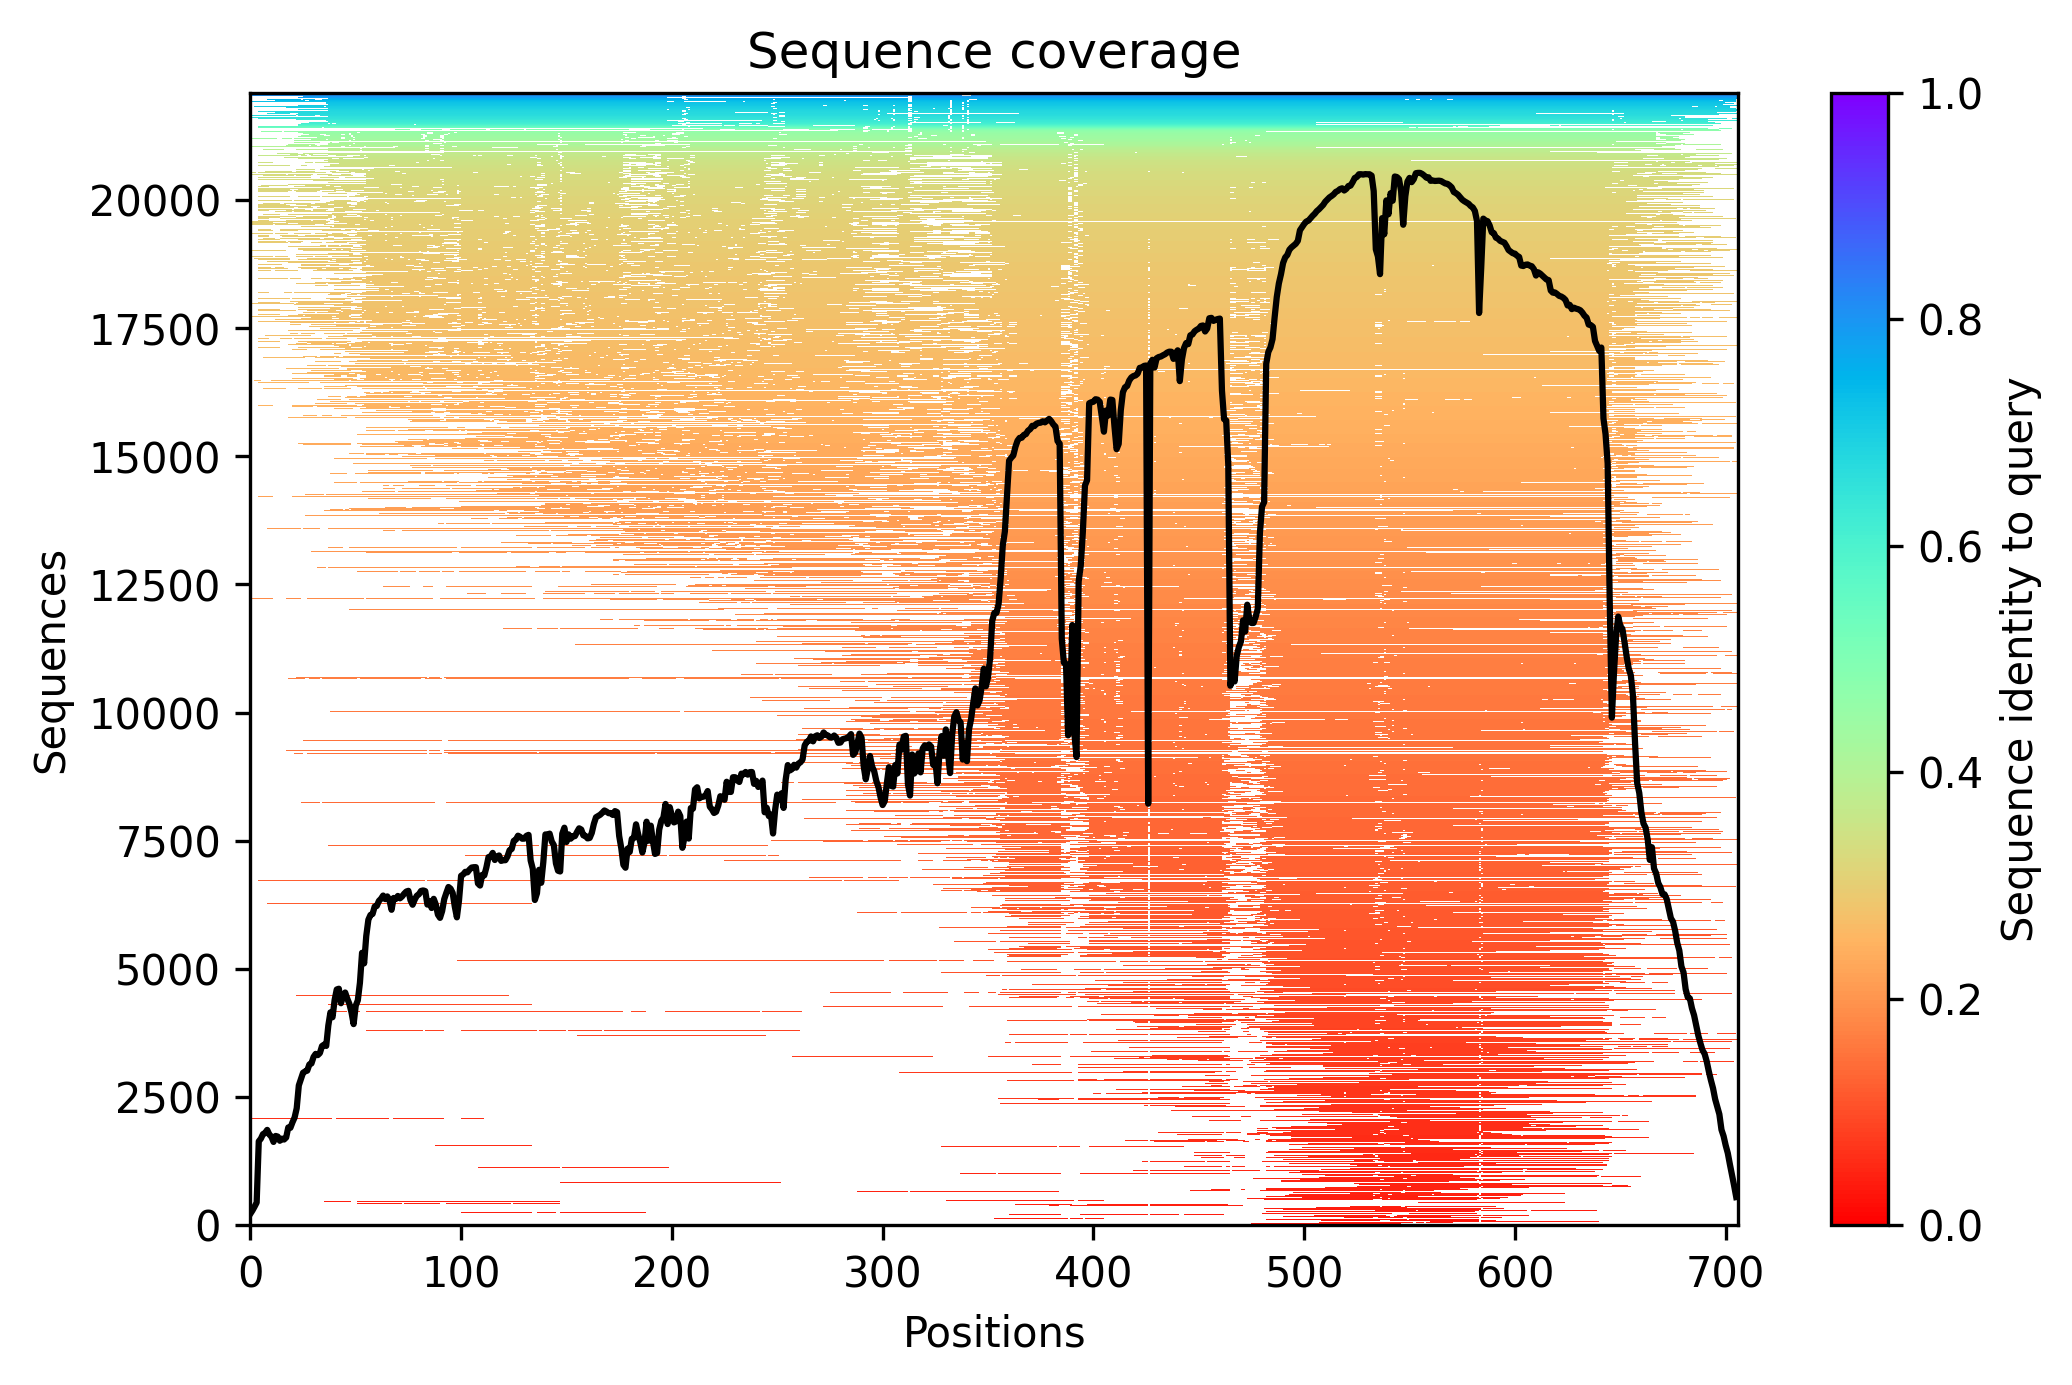

График показывает, что предсказанная структура не полностью соотвествует структуке белков содержащихся в базе `NCBI`. Модель недообучена.

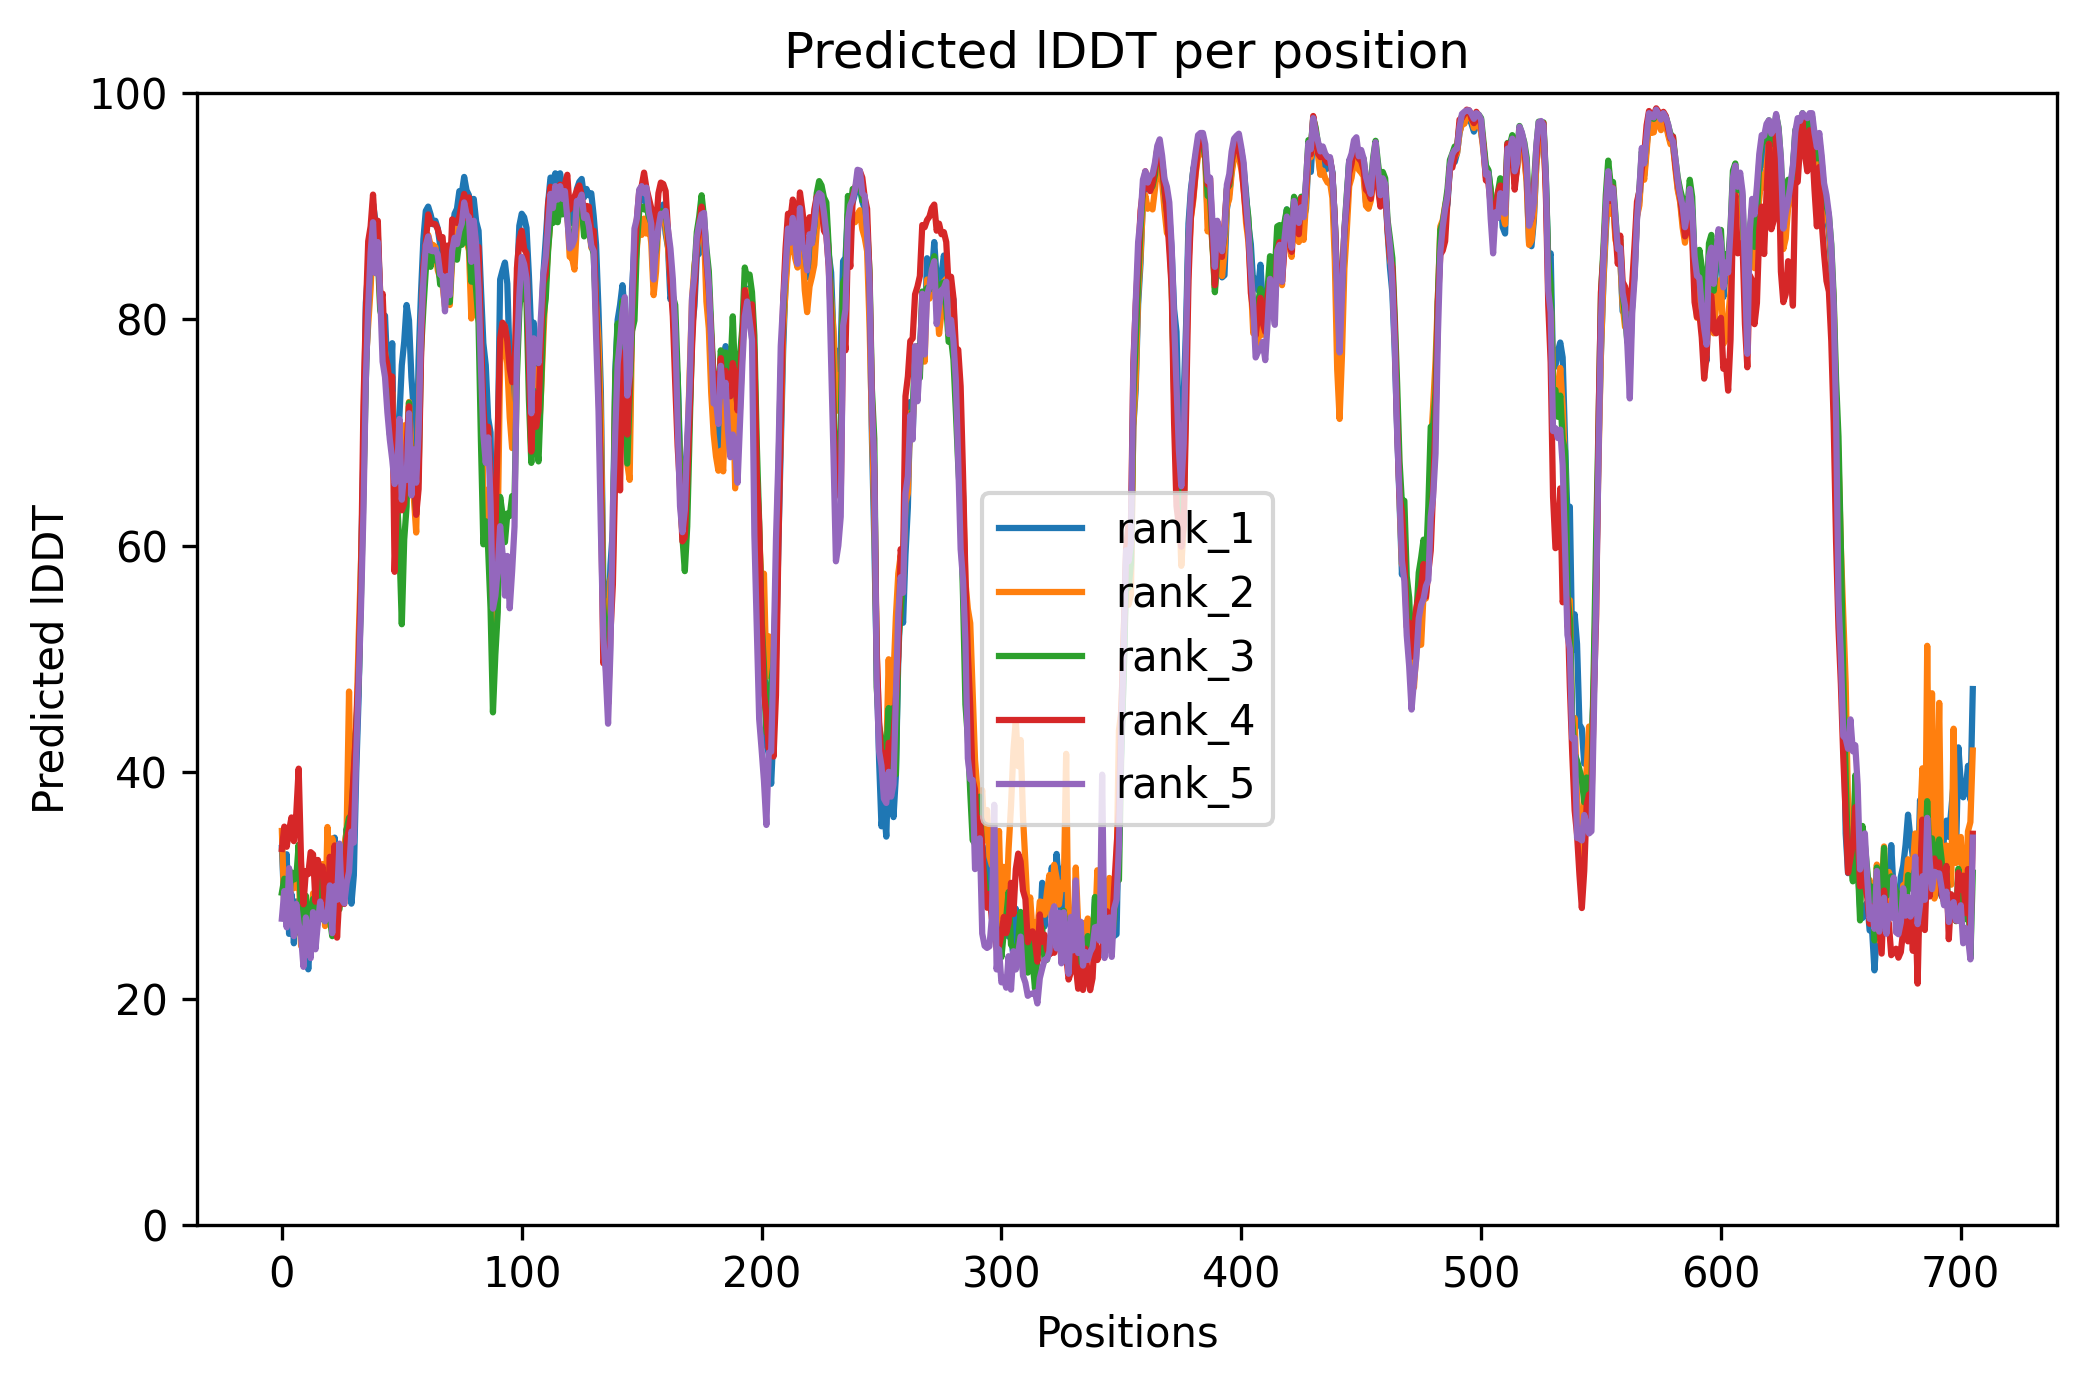

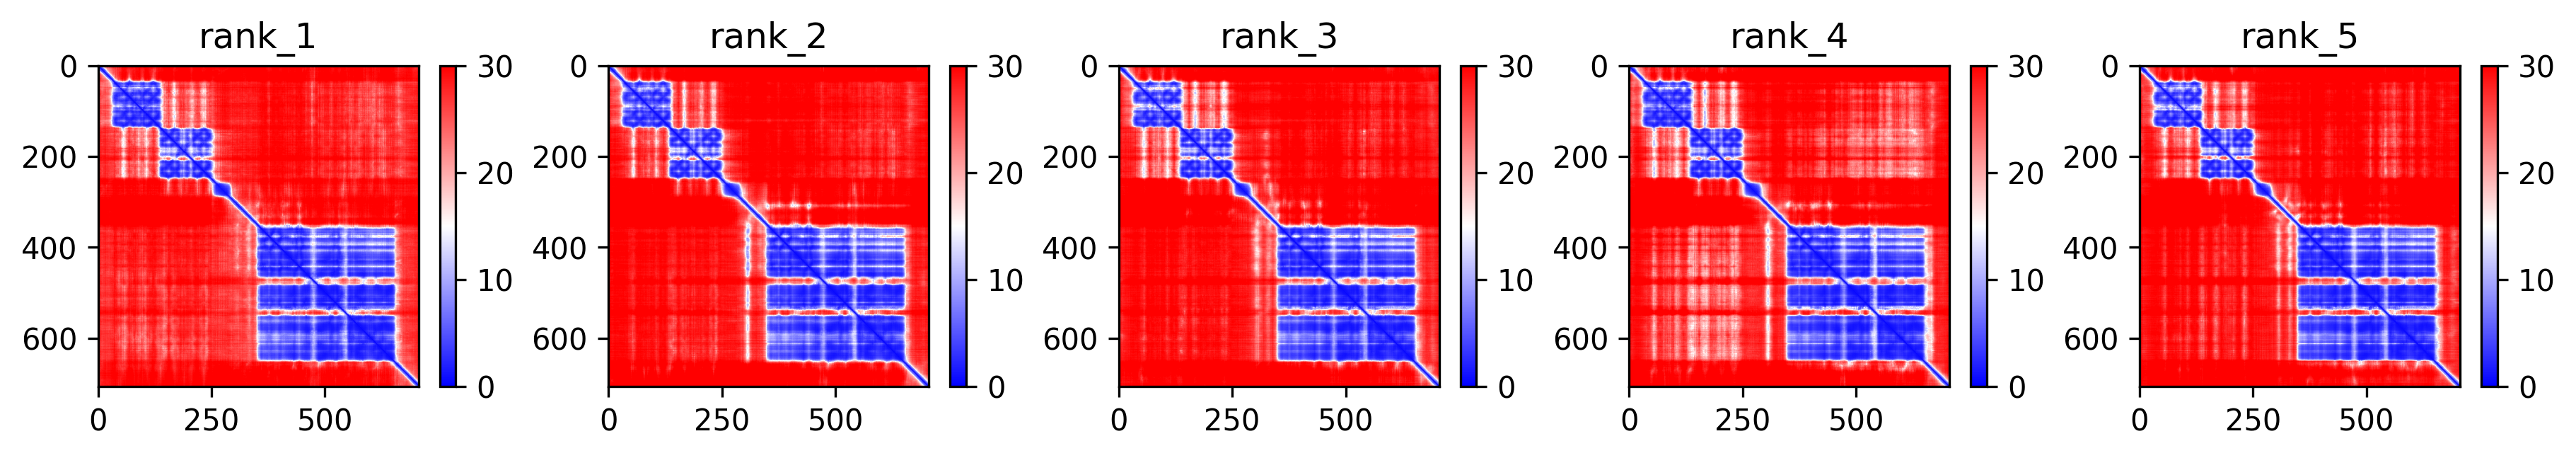

In [153]:
# !pip install nglview

In [ ]:
# from google.colab import output
# output.enable_custom_widget_manager()

In [ ]:
# import nglview as nv
# from Bio.PDB.PDBParser import PDBParser

# # Create a new instance of the PDBParser object
# pdb_parser = PDBParser()

# # Parse the PDB file and get a structure
# structure = pdb_parser.get_structure('protein', '/content/drive/MyDrive/Colab_Notebooks/GB/HW_5_files/FGFR2_05cfe/FGFR2_05cfe_unrelaxed_rank_005_alphafold2_ptm_model_3_seed_000.pdb')

# # Create an NGLViewer object and add the structure to it

# # Set the background color to white
# view.background = 'white'

# # Show the view
# view

In [140]:
!pip install py3dmol

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [142]:
!pip install colabfold

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 KB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.1/132.1 KB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 284.5/284.5 KB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.8/231.8 MB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.9/40.9 MB 16.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 60.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.4/302.4 KB 18.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 221.5/221.5 MB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 221.5/221.5 MB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 214.5/214.5 MB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

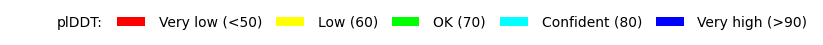

In [148]:
#@title Display 3D structure [Alpha Fold] {run: "auto"}
import py3Dmol
import glob
import matplotlib.pyplot as plt
from colabfold.colabfold import plot_plddt_legend
from colabfold.colabfold import pymol_color_list, alphabet_list
rank_num = 1 #@param ["1", "2", "3", "4", "5"] {type:"raw"}
color = "lDDT" #@param ["chain", "lDDT", "rainbow"]
show_sidechains = False #@param {type:"boolean"}
show_mainchains = False #@param {type:"boolean"}

# tag = results["rank"][0][rank_num - 1]
# jobname_prefix = ".custom" if msa_mode == "custom" else ""
# pdb_filename = f"{jobname}/{jobname}{jobname_prefix}_unrelaxed_{tag}.pdb"
# pdb_file = glob.glob(pdb_filename)

pdb_filename = f"/content/drive/MyDrive/Colab_Notebooks/GB/HW_5_files/FGFR2_05cfe/FGFR2_05cfe_unrelaxed_rank_005_alphafold2_ptm_model_3_seed_000.pdb"
pdb_file = glob.glob(pdb_filename)

def show_pdb(rank_num=1, show_sidechains=False, show_mainchains=False, color="lDDT"):
  model_name = f"rank_{rank_num}"
  view = py3Dmol.view(js='https://3dmol.org/build/3Dmol.js',)
  view.addModel(open(pdb_file[0],'r').read(),'pdb')

  if color == "lDDT":
    view.setStyle({'cartoon': {'colorscheme': {'prop':'b','gradient': 'roygb','min':50,'max':90}}})
  elif color == "rainbow":
    view.setStyle({'cartoon': {'color':'spectrum'}})
  elif color == "chain":
    chains = len(queries[0][1]) + 1 if is_complex else 1
    for n,chain,color in zip(range(chains),alphabet_list,pymol_color_list):
       view.setStyle({'chain':chain},{'cartoon': {'color':color}})

  if show_sidechains:
    BB = ['C','O','N']
    view.addStyle({'and':[{'resn':["GLY","PRO"],'invert':True},{'atom':BB,'invert':True}]},
                        {'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
    view.addStyle({'and':[{'resn':"GLY"},{'atom':'CA'}]},
                        {'sphere':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
    view.addStyle({'and':[{'resn':"PRO"},{'atom':['C','O'],'invert':True}]},
                        {'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})  
  if show_mainchains:
    BB = ['C','O','N','CA']
    view.addStyle({'atom':BB},{'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})

  view.zoomTo()
  return view

show_pdb(rank_num, show_sidechains, show_mainchains, color).show()
if color == "lDDT":
  plot_plddt_legend().show()

In [152]:
#@title Display 3D structure [NCBI] {run: "auto"}
import py3Dmol
import glob
import matplotlib.pyplot as plt
from colabfold.colabfold import plot_plddt_legend
from colabfold.colabfold import pymol_color_list, alphabet_list
rank_num = 5 #@param ["1", "2", "3", "4", "5"] {type:"raw"}
color = "rainbow" #@param ["chain", "lDDT", "rainbow"]
show_sidechains = False #@param {type:"boolean"}
show_mainchains = False #@param {type:"boolean"}

# tag = results["rank"][0][rank_num - 1]
# jobname_prefix = ".custom" if msa_mode == "custom" else ""
# pdb_filename = f"{jobname}/{jobname}{jobname_prefix}_unrelaxed_{tag}.pdb"
# pdb_file = glob.glob(pdb_filename)

pdb_filename = f"/content/drive/MyDrive/Colab_Notebooks/GB/HW_5_files/6LVL.pdb"
pdb_file = glob.glob(pdb_filename)

def show_pdb(rank_num=1, show_sidechains=False, show_mainchains=False, color="lDDT"):
  model_name = f"rank_{rank_num}"
  view = py3Dmol.view(js='https://3dmol.org/build/3Dmol.js',)
  view.addModel(open(pdb_file[0],'r').read(),'pdb')

  if color == "lDDT":
    view.setStyle({'cartoon': {'colorscheme': {'prop':'b','gradient': 'roygb','min':50,'max':90}}})
  elif color == "rainbow":
    view.setStyle({'cartoon': {'color':'spectrum'}})
  elif color == "chain":
    chains = len(queries[0][1]) + 1 if is_complex else 1
    for n,chain,color in zip(range(chains),alphabet_list,pymol_color_list):
       view.setStyle({'chain':chain},{'cartoon': {'color':color}})

  if show_sidechains:
    BB = ['C','O','N']
    view.addStyle({'and':[{'resn':["GLY","PRO"],'invert':True},{'atom':BB,'invert':True}]},
                        {'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
    view.addStyle({'and':[{'resn':"GLY"},{'atom':'CA'}]},
                        {'sphere':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
    view.addStyle({'and':[{'resn':"PRO"},{'atom':['C','O'],'invert':True}]},
                        {'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})  
  if show_mainchains:
    BB = ['C','O','N','CA']
    view.addStyle({'atom':BB},{'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})

  view.zoomTo()
  return view

show_pdb(rank_num, show_sidechains, show_mainchains, color).show()
if color == "lDDT":
  plot_plddt_legend().show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

__Предсказанная модель имеет общие черты с референсной моделью `6LVL` (`MMDB ID: 186071`) содержащейся в базе данных.__
_____________________________________
[Human fibroblast growth factor receptor 2] рецептор фактора роста фибробластов 2 типа человека